In [1]:
import pandas as pd
import numpy as np

annotations = pd.read_csv('annotations.csv')

In [2]:
# !pip3 install tensorflow

In [3]:
annotations['image_name'] = annotations['image'].apply(lambda x: x.split('/')[-1])

In [4]:
annotations.head(3)

,image,id,street_width,annotator,annotation_id,pavement_type,pavement_quality,image_name
0,/data/upload/image26angle180.jpg,135,irrelevant_image,paulomanuelmaia@gmail.com,135,NaN,NaN,image26angle180.jpg
1,/data/upload/image13angle180.jpg,66,double_car_or_more,paulomanuelmaia@gmail.com,66,alcatrao,mid,image13angle180.jpg
2,/data/upload/image50angle0.jpg,249,irrelevant_image,paulomanuelmaia@gmail.com,249,NaN,NaN,image50angle0.jpg


In [5]:
annotations = pd.concat([annotations, pd.get_dummies(annotations['street_width'])], axis=1)
annotations = annotations.drop(columns=['double_car_or_more'])
# annotations['single_car'] = np.where(annotations['irrelevant_image'] == 1, np.nan, annotations['single_car'])

# remove other predictions in case image is irrelevant
#annotations['pavement_type'] = np.where(annotations['irrelevant_image'] == 1, np.nan, annotations['pavement_type'])
#annotations['pavement_quality'] = np.where(annotations['irrelevant_image'] == 1, np.nan, annotations['pavement_quality'])
#annotations['pavement_quality'] = np.where(annotations['pavement_type'] != 'alcatrao', np.nan, annotations['pavement_quality'])

quality_cols = pd.get_dummies(annotations['pavement_quality'])
quality_cols.columns = [x + '_quality' for x in quality_cols.columns]

annotations = pd.concat([annotations, quality_cols], axis=1)

annotations = pd.concat([annotations, pd.get_dummies(annotations['pavement_type'])], axis=1)

annotations = annotations.drop(columns=['annotation_id', 'pavement_type', 'pavement_quality', 'annotator', 'image'])

In [30]:
annotations['quality'] = annotations.apply(lambda x: [x.high_quality, x.low_quality, x.mid_quality], axis=1)

0      [0, 0, 0]
1      [0, 0, 1]
2      [0, 0, 0]
3      [1, 0, 0]
4      [0, 0, 0]
         ...    
246    [1, 0, 0]
247    [1, 0, 0]
248    [0, 1, 0]
249    [0, 0, 0]
250    [0, 0, 1]
Length: 251, dtype: object

Rules for annotation and modeling:

- Whenever image is "irrelevant", dont label anything else
- Whenever type is different from "alcatrão", don't label street quality

In [6]:
annotations.head(3)

,id,street_width,image_name,irrelevant_image,single_car,high_quality,low_quality,mid_quality,alcatrao,paralelo,terra_batida
0,135,irrelevant_image,image26angle180.jpg,1,0,0,0,0,0,0,0
1,66,double_car_or_more,image13angle180.jpg,0,0,0,0,1,1,0,0
2,249,irrelevant_image,image50angle0.jpg,1,0,0,0,0,0,0,0


In [7]:
import re

annotations['image_group'] = annotations.image_name.str.extract(r"(image\d{1,})")

,id,street_width,image_name,irrelevant_image,single_car,high_quality,low_quality,mid_quality,alcatrao,paralelo,terra_batida,image_group
105,173,irrelevant_image,image34angle180.jpg,1,0,0,0,0,0,0,0,image34
141,112,irrelevant_image,image22.jpg,1,0,0,0,0,0,0,0,image22
59,192,irrelevant_image,image38angle180.jpg,1,0,0,0,0,0,0,0,image38


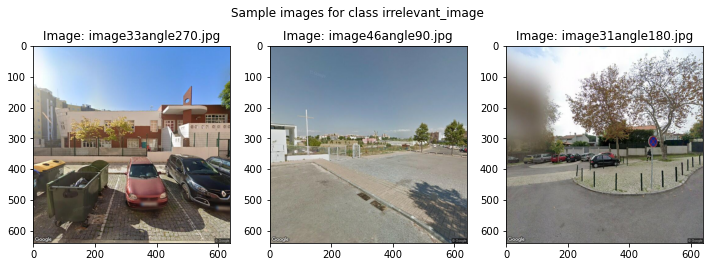

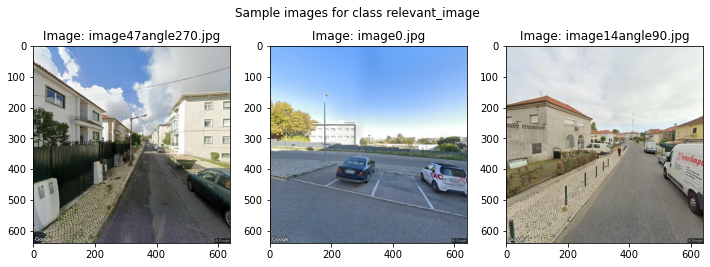

In [27]:
import matplotlib.pyplot as plt
import os

IMAGES_PATH = 'data/images/'
CLASS_NAME = 'irrelevant_image'
#fig1 = plt.imread(IMAGES_PATH + 'image26angle180.jpg')


def make_plot(masked_df, CLASS_NAME):
    images_name = list(masked_df.sample(3)['image_name'])
    images = [plt.imread(IMAGES_PATH + x) for x in images_name]
    # Show subplots | shape: (1,3) 
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
    for i, ax in enumerate(axs.flatten()):
        plt.sca(ax)
        plt.imshow(images[i])
        plt.title('Image: {}'.format(images_name[i]))

    plt.suptitle(f'Sample images for class {CLASS_NAME}')
    plt.show()
    
make_plot(annotations[annotations['irrelevant_image'] == 1], 'irrelevant_image')
make_plot(annotations[annotations['irrelevant_image'] == 0], 'relevant_image')

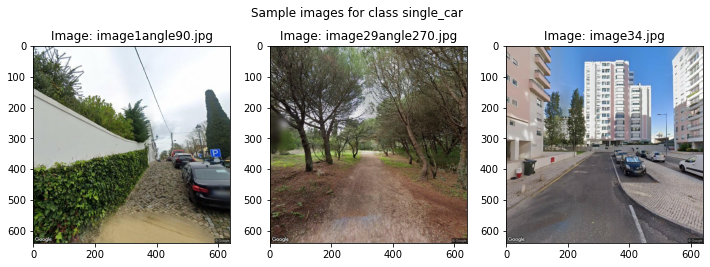

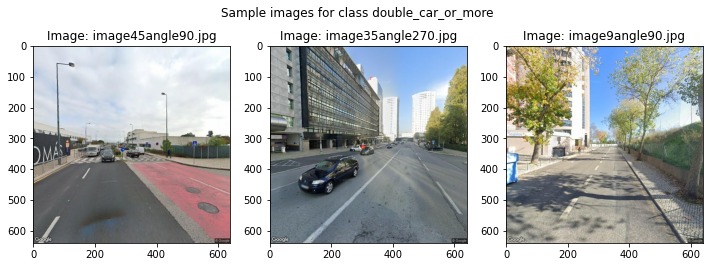

In [31]:
make_plot(annotations[annotations['single_car'] == 1], 'single_car')
make_plot(annotations[annotations['single_car'] == 0], 'double_car_or_more')

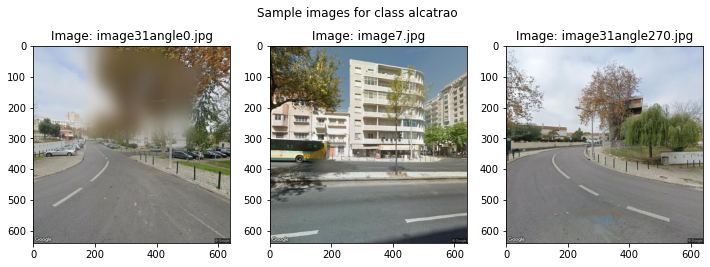

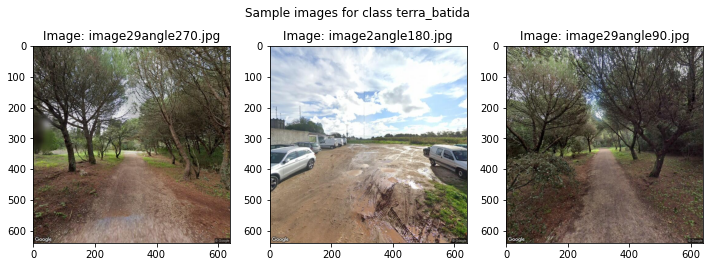

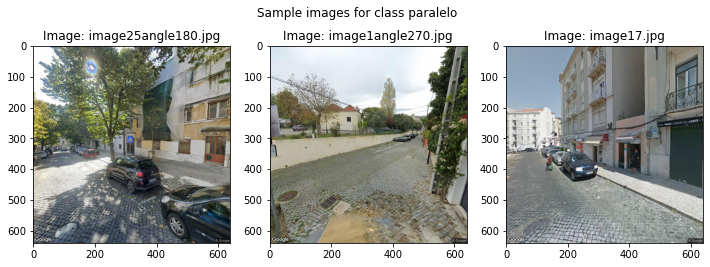

In [32]:
make_plot(annotations[annotations['alcatrao'] == 1], 'alcatrao')
make_plot(annotations[annotations['terra_batida'] == 1], 'terra_batida')
make_plot(annotations[annotations['paralelo'] == 1], 'paralelo')

In [ ]:
plot_images_per_class('irrelevant_image', show_positive_class_only=True)

In [ ]:
def model(
    lr=0.0001, input_shape=(224, 224, 3), base_model_trainable=False, model_name = 'irrelevant_vs_relevant'
):

    input_layer = Input(shape=input_shape, name="image")

    base_model = MobileNetV2(
        input_shape=input_shape, weights="imagenet", include_top=False, pooling="max"
    )

    if not base_model_trainable:
        base_model.trainable = False

    x = base_model(input_layer)

    x = Dense(200, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(50, activation="relu")(x)
    
    if model_name == 'irrelevant_vs_relevant'
        out = Dense(1, activation="sigmoid", name='irrelevant')(x)
    elif model_name == 'multitask':
        out_width = Dense(1, activation="sigmoid", name='single_car')(x)
        out_pavement = Dense(3, activation="softmax", name='pavement')(x)
    elif model_name == 'quality':
        out = Dense(3, activation='softmax', name='quality')
        
    # TODO: Para o multitask, tens de fazer duas losses
    """
    loss = {
        'single_car': binary_crossentropy,
        'pavement': categorical_crossentropy
    }
    """

    model = Model(input_layer, out)
    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer, "binary_crossentropy", ["accuracy"])

    return model